In [29]:
import glob
import librosa
import numpy as np
import os
import torch

from hparam import hparam as hp
from speech_embedder_net import SpeechEmbedder
from VAD_segments import VAD_chunk
import scipy.stats as stats
from dvector_create import concat_segs,get_STFTs, align_embeddings
from dvector_vis import visualization
import pandas
from tqdm import tqdm

#from tqdm import tqdm_notebook
import shutil

In [35]:
### Initialization
embedder_net = SpeechEmbedder()
embedder_net.load_state_dict(torch.load('../ckpt/ckpt_epoch_180_batch_id_1324.pth'))
embedder_net.eval()
train_sequence = []
train_cluster_id = []
df = pandas.read_csv("/Users/junhengwang/coop/court_data/00082.csv", delimiter=',')
mp3_file = '/Users/junhengwang/coop/court_data/82.mp3'
tmp_dir = './tmp/'
shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir, exist_ok=True)

In [36]:
### Concatenate intervals
concat_df = []
cur_speaker = df.iloc[0]['speaker']
cur_start = df.iloc[0]['start_time']
cur_end = df.iloc[0]['stop_time']
for index, row in df.iterrows():
    if row['speaker'] == cur_speaker:
        cur_end = row['stop_time']
    else:
        concat_df.append({'speaker':cur_speaker, 'start_time':cur_start, 'stop_time':cur_end })
        cur_speaker = row['speaker']
        cur_start = row['start_time']
        cur_end = row['stop_time']
else:
    concat_df.append({'speaker':cur_speaker, 'start_time':cur_start, 'stop_time':cur_end })
print(len(concat_df))

8


In [37]:
### Generate ffmpeg commands
ffm_command_path = tmp_dir + 'ffm_court.txt'
ffm_file = open(ffm_command_path,'w')
#for index, row in df.iterrows():
for index, row in enumerate(concat_df):
    start = float(row['start_time'])
    duration = float(row['stop_time']) - start 
    if duration < 2: continue # skip it if it is too short
    audio_file = tmp_dir + str(index) + '.wav'
    bashCommand = "ffmpeg -ss " + str(round(start,2)) + " -t " + str(round(duration,2)) + " -i " + mp3_file + ' -y -ar 16000 ' +  audio_file
    ffm_file.write(bashCommand + '\n')
ffm_file.close()

In [38]:
### Run ffmpeg in parallel
import subprocess
bashCommand = "parallel -j 50 :::: " + ffm_command_path
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output)
print(error)

b''
None


In [39]:
### Create dvector for each audio
import re
def create_dvector():
    audio_files = sorted(glob.glob(tmp_dir + '*.wav'), key=lambda x:int(os.path.basename(x)[:-4]))
    vis_file = open(tmp_dir + "visualization.csv","a+")
    for audio_file in tqdm(audio_files):
        speaker_name = re.sub('[^A-Za-z0-9]+','', concat_df[int(os.path.basename(audio_file)[:-4])]['speaker'])
        try:
            times, segs = VAD_chunk(2, audio_file)
        except:
            print(audio_file + ' is broken')
            continue
        if segs == []:
            print('No voice activity detected in ' + audio_file)
            continue
        concat_seg = concat_segs(times, segs)
        STFT_frames = get_STFTs(concat_seg)
        if not STFT_frames: 
            print('No STFT frames extracted in ' + audio_file)
            continue
        STFT_frames = np.stack(STFT_frames, axis=2)
        STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
        embeddings = embedder_net(STFT_frames) ### slow
        aligned_embeddings = align_embeddings(embeddings.detach().numpy())
        train_sequence.append(aligned_embeddings)
        for embedding in aligned_embeddings:
            train_cluster_id.append(speaker_name)
        ### save npz for visulization, may need to clean csv first
        for index, emb in enumerate(aligned_embeddings):
            save_path = tmp_dir + str(speaker_name) + str(index) + '.npz'
            save_sequence = np.array([emb])
            save_id = np.array([speaker_name] * len(aligned_embeddings))
            np.savez(save_path, train_sequence=save_sequence, train_cluster_id=np.array([speaker_name]))
            vis_file.write(save_path + '\n')
    vis_file.close()
%prun create_dvector()
create_dvector()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:33<00:00,  6.89s/it]


In [20]:
### Saving dvectors
train_sequence = np.concatenate(train_sequence,axis=0)
train_cluster_id = np.asarray(train_cluster_id)
np.save('court_test_sequence',train_sequence)
np.save('court_test_cluster_id',train_cluster_id)
print(train_sequence.shape)
print(train_cluster_id.shape)

(8113, 256)
(8113,)


In [21]:
print("Speakers:")
print(set(train_cluster_id))

Speakers:
{'NeilGorsuch', 'ErinEMurphy', 'JohnGRobertsJr', 'ElenaKagan', 'PaulMSmith', 'SamuelAAlitoJr', 'StephenGBreyer', 'MishaTseytlin', 'SoniaSotomayor', 'RuthBaderGinsburg', 'AnthonyMKennedy'}


######## TEST 1 #######
Num of true labels:6
Num of predicted labels:3
Accuracy:0.7893333333333333


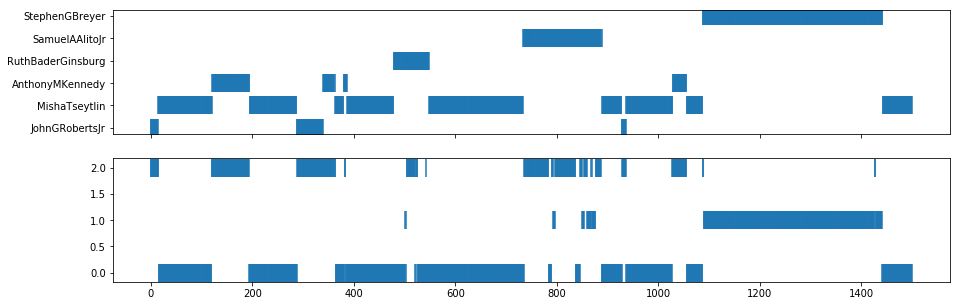

######## TEST 2 #######
Num of true labels:9
Num of predicted labels:7
Accuracy:0.9273333333333333


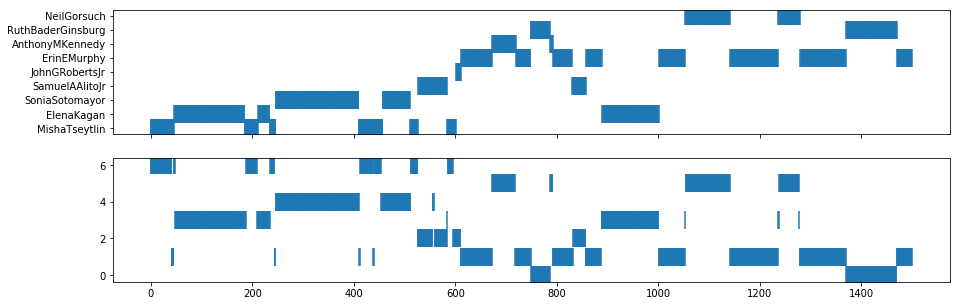

######## TEST 3 #######
Num of true labels:8
Num of predicted labels:3
Accuracy:0.734


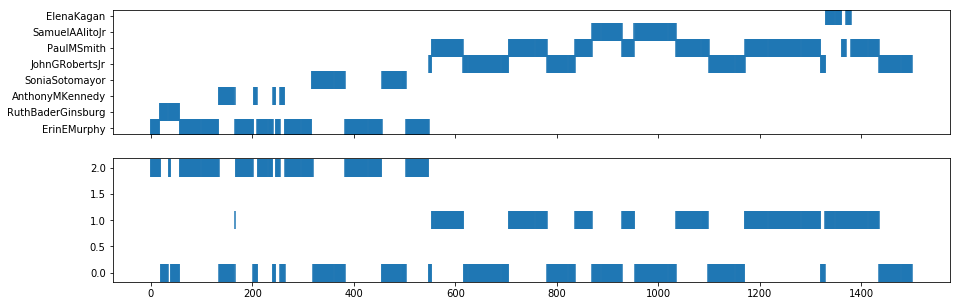

######## TEST 4 #######
Num of true labels:5
Num of predicted labels:5
Accuracy:0.9366666666666666


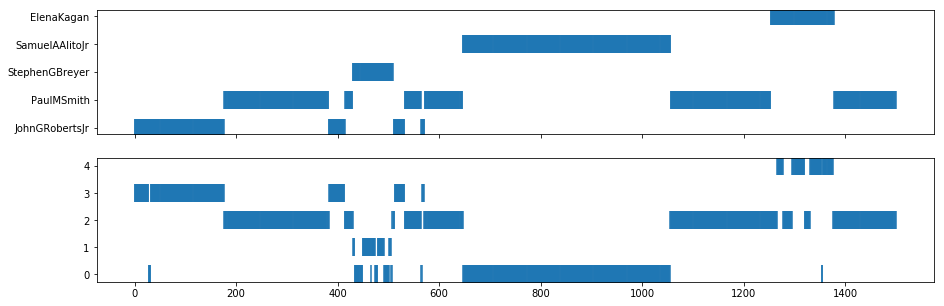

######## TEST 5 #######
Num of true labels:6
Num of predicted labels:3
Accuracy:0.8306666666666667


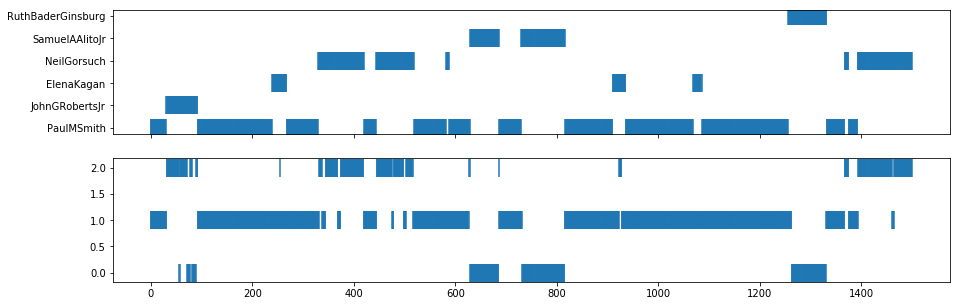

######## TEST 6 #######
Num of true labels:5
Num of predicted labels:3
Accuracy:0.933115823817292


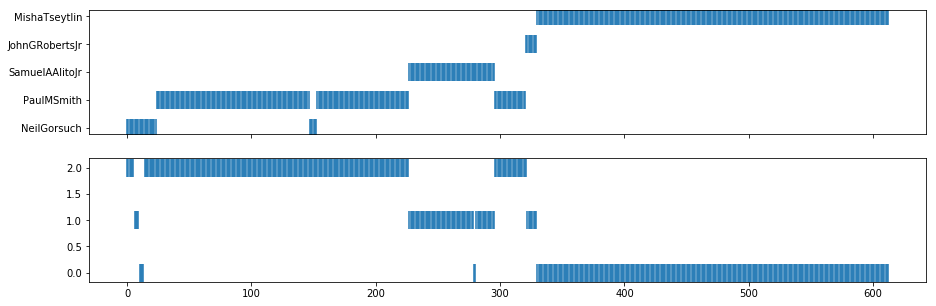

Average accuracy:0.8585193039695486


In [28]:
### Spectral Clustering
from spectralcluster import SpectralClusterer
import numpy as np
import uisrnn
import matplotlib.pyplot as plt

test_sequences = np.load('court_test_sequence.npy')
test_cluster_ids = np.load('court_test_cluster_id.npy')
test_size = 1500
test_sequences = np.array([np.array(test_sequences[i:i + test_size]) for i in range(0, len(test_sequences), test_size)])
test_cluster_ids = [list(test_cluster_ids[i:i + test_size]) for i in range(0,len(test_cluster_ids),test_size)]
index = 1
accuracy_lst = []
for sequence, cluster_ids in zip(test_sequences, test_cluster_ids):
    print("######## TEST " + str(index) + " #######")
    print("Num of true labels:" + str(len(set(cluster_ids))))
    clusterer = SpectralClusterer(min_clusters=3,max_clusters=20,p_percentile=0.92,gaussian_blur_sigma=2)
    labels = clusterer.predict(sequence)
    print("Num of predicted labels:" + str(len(set(labels))))
    accuracy = uisrnn.compute_sequence_match_accuracy(list(cluster_ids), list(labels))
    accuracy_lst.append(accuracy)
    print("Accuracy:" + str(accuracy))
    index += 1
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 5))
    ax1.scatter(range(len(cluster_ids)), cluster_ids, s=300, marker='|')
    ax2.scatter(range(len(labels)), labels, s=300, marker='|')
    plt.show()
print('Average accuracy:' + str(np.mean(accuracy_lst)))

Observation from spectral:

1. Could not predicted the number of speakers correctly mostly because some speakers have too few dvectors. 

Observation from visualization:

1. There is a big region of scatter, possibly due to noise

2. The embedding model seems to be not robust enough.

  2%|▏         | 49/3000 [00:00<00:06, 481.43it/s]

./tmp/visualization.csv


100%|██████████| 3000/3000 [00:03<00:00, 820.47it/s]


==> Finish loading
==> Finish pca
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.025s...
[t-SNE] Computed neighbors for 3000 samples in 4.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.005207
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.625214
[t-SNE] KL divergence after 300 iterations: 1.417519
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


==> Finish tsne


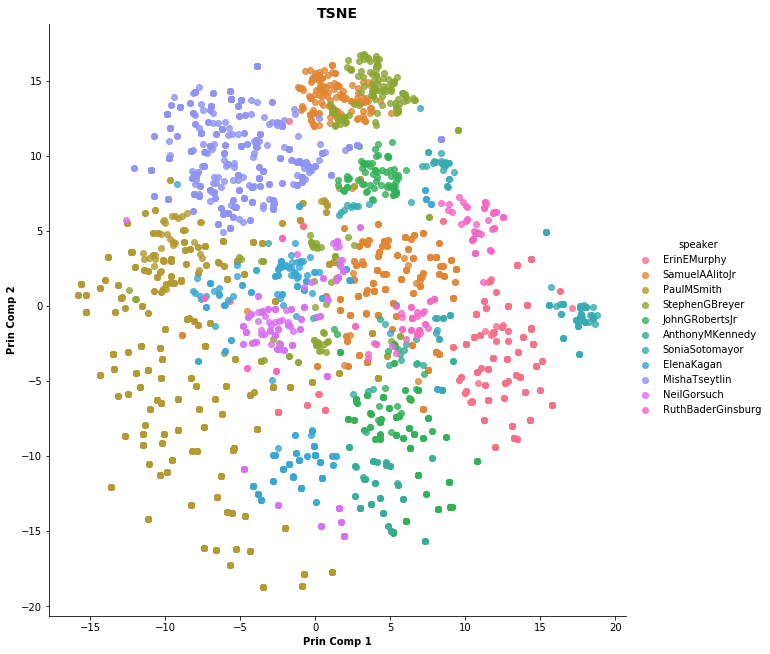

In [23]:
visualization(tmp_dir + 'visualization.csv', 3000)

In [ ]:
'''
MULTIPROCESSING
from multiprocessing import Pool
audio_files = sorted(glob.glob(tmp_dir + '*.wav'), key=lambda x:int(os.path.basename(x)[:-4]))
vis_file = open(tmp_dir + "visualization.csv","a+")

def parall_create_dvectors(audio_file):
    speaker_name = concat_df[int(os.path.basename(audio_file)[:-4])]['speaker']
    #speaker_name = df.iloc[int(os.path.basename(audio_file)[:-4])]['speaker']
    try:
        times, segs = VAD_chunk(2, audio_file)
    except:
        print(audio_file + ' is broken')
        return
    if segs == []:
        print('No voice activity detected in ' + audio_file)
        return
    concat_seg = concat_segs(times, segs)
    STFT_frames = get_STFTs(concat_seg)
    if not STFT_frames: 
        print('No STFT frames extracted in ' + audio_file)
        return
    STFT_frames = np.stack(STFT_frames, axis=2)
    STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
    embeddings = embedder_net(STFT_frames)
    aligned_embeddings = align_embeddings(embeddings.detach().numpy())
    return aligned_embeddings, speaker_name
NUM_PROCESSES = 4
pool = Pool(NUM_PROCESSES)
results = pool.map(parall_create_dvectors, audio_files)

results = [res for res in results if res]
for res in results:
    # for clustering
    speaker_name = res[1]
    train_sequence.append(res[0])
    for embedding in res[0]:
        train_cluster_id.append(res[1])
    # for visualization
    for index, emb in enumerate(res[0]):
        save_path = tmp_dir + str(speaker_name) + str(index) + '.npz'
        save_sequence = np.array([emb])
        np.savez(save_path, train_sequence=save_sequence, train_cluster_id=np.array([speaker_name]))
        vis_file.write(save_path + '\n')
vis_file.close()
'''